# Transfer Learning et Fine-Tuning : Skin lesion image classification

Groupe : 
    
        *  HADROUCH Chaimae  
        *  AIT-AHMAD Kaoutar 


         

L'objectif du projet est de réaliser un systeme de classification composé de plusieurs étapes. Il y a plusieurs méthodes soit construire un CNN à partir de zéro, soit adopter un encodeur comme le ResNet ou le VGG qui ont plusieurs types.

Pour réaliser ce projet, nous avons adopté le ResNet-50 qui est une architecture de réseau convolutif donnant des très bonnes performances et largement utilisé dans le domaine de la vision par ordinateur et Deep Learning. Il comporte 48 couches de convolution avec 1 couche MaxPool et 1 couche Average Pool. Il comporte 3.8 x 10^9 opérations en virgule flottante.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Mar  6 15:21:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing libraries

In [3]:
import numpy as np             # linear algebra
import pandas as pd            # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image

import os
import time
import copy
from tqdm import tqdm  

import torch                   # PyTorch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torchvision
from torchvision import transforms, models, datasets # importer le modèle à utiliser
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print ("done importing")

done importing


In [4]:
torch.manual_seed(0) # génération de nombres aléatoires

## Read data

In [5]:
# Short names of categories
classes = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]

# Path to image data
#img_path="../input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
img_path='/content/drive/MyDrive/MLTPs/Projet/'

# Load data frame containing category annotations
df_all = pd.read_csv(os.path.join(img_path,"gt_train_test.csv"))

# data frame for training (with categories)
df_annot = df_all[df_all['target']>=0]

# data frame for testing (without categories)
df_test = df_all[df_all['target']<0]

# load or image data
#img_data_tensor = np.load('../input/iogs-atsi-skin-classification-2022/isic2019_img_data.npz')
if (os.path.exists(os.path.join(img_path,'isic2019_img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(img_path,'isic2019_img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []

  # To create square image
  def center_crop(pil_img):
      img_width, img_height = pil_img.size
      if img_width > img_height:
          crop_size = img_height
      else:
          crop_size = img_width
      return pil_img.crop(((img_width - crop_size) // 2,
                          (img_height - crop_size) // 2,
                          (img_width + crop_size) // 2,
                          (img_height + crop_size) // 2))
      
  for im in tqdm(df_all['image']):
      x = Image.open(os.path.join(img_path, "{}.jpg".format(im)))
      x = center_crop(x)
      img_all.append(np.array(x.resize((224,224))))

  np.savez_compressed(os.path.join(img_path,'isic2019_img_data_224.npz'), img_data=np.array(img_all))

y_all = df_all['target']

print(img_all.shape)

(25331, 224, 224, 3)


## Create dataset

In [6]:
# Create train, val and test splits
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(img_all[df_all['target']>=0,:,:,:], y_all[df_all['target']>=0], test_size=0.2, random_state=123)

x_test = img_all[df_all['target']<0,:,:,:]
y_test = y_all[df_all['target']<0]


In [7]:
# Create dataset
class MyDatasetRaw(Dataset):
    """ISIC 2019 dataset."""
    # classes = {'NV': 0, 'MEL': 1, 'BKL': 2, 'DF': 3, 'SCC': 4, 'BCC': 5, 'VASC': 6, 'AK': 7}
    
    def __init__(self, raw_data, targets, transform=None):
        """
        Args:
        """
        self.raw_data = raw_data
        self.targets = targets
        self.transform = transform        
    
    def __getitem__(self, idx):
        x = Image.fromarray(self.raw_data[idx, :, :, :])
        #x = read_image(os.path.join(self.img_path, "{}.jpg".format(image_id)))
        x = self.center_crop(x)
        if self.transform:
            x = self.transform(x)
        y = self.targets.iloc[idx]
        y = np.int64(y)
        id=self.targets.index[idx]
        return {"image": x, "label": y, "Id": id}
            
    def __len__(self):
        return int(len(self.raw_data))
    
    # To create square image
    def center_crop(self, pil_img):
        img_width, img_height = pil_img.size
        if img_width > img_height:
            crop_size = img_height
        else:
            crop_size = img_width
        return pil_img.crop(((img_width - crop_size) // 2,
                             (img_height - crop_size) // 2,
                             (img_width + crop_size) // 2,
                             (img_height + crop_size) // 2))


## Select device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Create data loaders

In [9]:
#batch_size = 25
batch_size = 32
input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_set_raw = MyDatasetRaw(x_train, y_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)

val_set_raw = MyDatasetRaw(x_val, y_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

In [10]:
draw = {'train': train_set_raw,    # set the dictionnary for the training and validation phases
        'valid': val_set_raw} 
image_datasets = {x: draw[x]
                  for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
# set a dictionnary for the dataloaders
dataloaders = {x: DataLoader(draw[x], batch_size=16, shuffle=True, **kwargs) for x in ['train', 'valid']}

## Test data loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


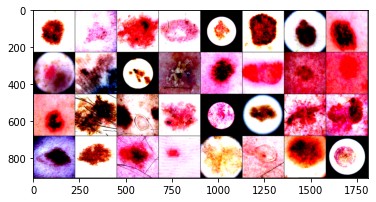

In [11]:
it = iter(val_dataloader)     # iterate over validation dataloader
sample = it.next()

out = torchvision.utils.make_grid(sample['image'])
plt.imshow(out.permute(1, 2, 0))

## The neural network architecture : Resnet-50

### Create training function

In [12]:
def model_training(model, criterion, optimizer, scheduler, num_epochs):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc = []
    valid_acc = []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))    # each epoch has a training and validation phase
        print('-' * 10)

       
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()            # set model to training mode
            else:
                model.eval()             # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for sample in dataloaders[phase]:      # iterate over data.
                inputs = sample['image']           # take the image from the dataloader
                labels = sample['label']           # take the label from the dataloader
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                with torch.set_grad_enabled(phase == 'train'):      # track history if only in train
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward  
                    if phase == 'train':
                        optimizer.zero_grad()      # optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]   
            epoch_acc = running_corrects.double() / dataset_sizes[phase]    # calculate training accuracy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            train_acc.append(epoch_acc)

            if phase == 'valid' and epoch_acc > best_acc:       # deep copy the model
                best_acc = epoch_acc                            # calculate validation accuracy
                best_model_wts = copy.deepcopy(model.state_dict())     
                valid_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since                          # time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)       # load best model weights

    return model, train_acc, valid_acc

## Load the pretrained model Resnet-50

In [4]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Finetuning

Ici, nous utilisons le resnet-50 pour notre dataset, qui a 8 classes. Comme tous les modèles qui ont été pré-entraînés sur Imagenet, ils ont tous des couches de sortie de taille 1000. Le but ici est de remodeler la dernière couche pour avoir le même nombre de sorties que le nombre de classes dans notre ensemble de données qui est 8 classes :

*   Melanoma ("MEL" = 0)
*   Melanocytic nevus ("NV" = 1)
*   Basal cell carcinoma ("BCC" = 2)
*   Actinic keratosis ("AK" = 3)
*   Benign keratosis ("BKL" = 4)
*   Dermatofibroma ("DF" = 5)
*   Vascular lesion ("VASC" = 6)
*   Squamous cell carcinoma ("SCC" = 7)

Nous allons changer donc la sortie de la dernière couche FC à 8. 

In [14]:
num_ftrs = model.fc.in_features     # reset final fully connected layer
model.fc = nn.Linear(num_ftrs, 8)   # 8 outputs which is the number of classes

In [ ]:
model = model.to(device)    # move the model to the device

La couche finale FC de notre modèle, possède le même nombre de nœuds que le nombre de classes de sortie dans l'ensemble de dataset. 

## Optimization and setting Hyperparameters 

Nous observons que tous les paramètres sont optimisés


In [16]:
criterion = F.cross_entropy   # compute the cross entropy loss between input and target

grad_clip = 0.1
weight_d = 0.00015    # add a small penalty

num_epochs = 25       # chose number of epochs
lr_m = 0.0007         # set the learning rate and decay LR by a factor of 0.1 every 7 epochs

##optimizer = optim.SGD(model.parameters(), lr=0.0007)

optimizer = torch.optim.Adam(model.parameters(), lr = lr_m, weight_decay = weight_d) # set Adam optimizer

# Learning rate scheduling should be applied after optimizer’s update
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_m, epochs=num_epochs, 
                                                steps_per_epoch=len(train_dataloader))


## Training the whole network

In [17]:
model = model_training(model, criterion, optimizer, lr_scheduler, num_epochs)

Epoch 0/24
----------
train Loss: 0.9046 Acc: 0.6825
valid Loss: 0.6926 Acc: 0.7467

Epoch 1/24
----------
train Loss: 0.6925 Acc: 0.7486
valid Loss: 0.6236 Acc: 0.7776

Epoch 2/24
----------
train Loss: 0.5956 Acc: 0.7837
valid Loss: 0.5988 Acc: 0.7884

Epoch 3/24
----------
train Loss: 0.4984 Acc: 0.8196
valid Loss: 0.6148 Acc: 0.7851

Epoch 4/24
----------
train Loss: 0.4379 Acc: 0.8416
valid Loss: 0.5478 Acc: 0.8059

Epoch 5/24
----------
train Loss: 0.3687 Acc: 0.8659
valid Loss: 0.5665 Acc: 0.8070

Epoch 6/24
----------
train Loss: 0.3216 Acc: 0.8839
valid Loss: 0.5948 Acc: 0.8046

Epoch 7/24
----------
train Loss: 0.2754 Acc: 0.9029
valid Loss: 0.5690 Acc: 0.8162

Epoch 8/24
----------
train Loss: 0.2443 Acc: 0.9133
valid Loss: 0.5937 Acc: 0.8167

Epoch 9/24
----------
train Loss: 0.2070 Acc: 0.9273
valid Loss: 0.5911 Acc: 0.8110

Epoch 10/24
----------
train Loss: 0.1901 Acc: 0.9339
valid Loss: 0.6161 Acc: 0.8072

Epoch 11/24
----------
train Loss: 0.1786 Acc: 0.9375
valid Loss

Puisque nous avons utilisé deux méthodes pour la prédiction des classes, nous déduisons que le Resnet-50 avec ces hyperparamètres est meilleur qu'un simple CNN car nous avons atteint une accuracy de 83.221% avec un temps de training de 94m 20s.

## Save the best model

In [18]:
torch.save(model[0].state_dict(), '/content/drive/MyDrive/MLTPs/Projet/modelth_resnet50.pt')

## Submission

In [19]:
test_set_raw = MyDatasetRaw(x_test, y_test, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=100, shuffle=False, **kwargs)

submission=pd.DataFrame(df_test[['Id']])
submission['target'] = -1

tag = "modelth_resnet50.pt"

if (os.path.exists(os.path.join(img_path, '{}'.format(tag)))):
  print('Resume from last learning step')
  #network = torch.load(os.path.join(img_path, '{}.pt'.format(tag)))
  model[0].load_state_dict(torch.load(os.path.join(img_path, tag)))
  model[0].to(device)

  model[0].eval()

  with torch.no_grad():
          for samples in tqdm(test_dataloader, ncols=80, desc=" Test "):

              inputs = samples['image']
              targets = samples['label']
              ids = samples['Id'].numpy()
              
              inputs = inputs.to(device)
              targets = targets.to(device)

              # compute outputs
              outputs = model[0](inputs)

              outputs_np = outputs.cpu().detach().numpy()
              targets_np = targets.cpu().detach().numpy()
          
              # compute the predictions
              pred = np.argmax(outputs_np, axis=1)
              
              submission['target'][ids] = pred
              
  submission.to_csv(os.path.join(img_path,'submission_2{:s}.csv'.format(tag)), index=False)

  print(submission.head(20))

Resume from last learning step


 Test : 100%|███████████████████████████████████| 26/26 [00:07<00:00,  3.56it/s]

      Id  target
0      0       1
13    13       1
25    25       1
30    30       0
36    36       1
37    37       1
50    50       1
55    55       1
59    59       1
65    65       1
67    67       1
78    78       1
96    96       1
105  105       1
117  117       1
118  118       0
164  164       1
174  174       1
175  175       1
194  194       1


In [ ]:
# Verify that all classes are predicted
print(np.unique(submission['target'].to_numpy()))